# 📈 Results

This notebook analyses the results of experiments as tracked to W&B.


## Setup 

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import autorootcwd

In [3]:
# Imports
from typing import Dict, Tuple
from tqdm import tqdm

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import wandb
from wandb.sdk.wandb_run import Run

In [4]:
# Constants
WANDB_ENTITY = "mikasenghaas"
WANDB_PROJECT = "swarm"

In [5]:
# Helpers
def get_gpu(run: Run) -> str:
    if "gpu_nvidia" in run.metadata:
        gpu = run.metadata["gpu_nvidia"][0]
        return {"name": gpu["name"], "memory": gpu["memoryTotal"], "count": len(run.metadata["gpu_nvidia"])}
    elif "gpuapple" in run.metadata:
        return {"name": run.metadata["gpuapple"]["gpuType"], "count": 1}
    else:
        return {"name": "Unknown"}

def get_metadata(run: Run) -> Tuple:
    return run.id, run.group, run.name, run.config, run.summary

def get_history(run: Run) -> pd.DataFrame:
    run_id = run.id
    return run.history()

In [6]:
# Styling
sns.set_theme(style="whitegrid")
sns.set_palette("Blues_r")

In [7]:
# Initialize W&B
api = wandb.Api()

# Get runs
ALL_RUNS = api.runs(f"{WANDB_ENTITY}/{WANDB_PROJECT}")
print(f"✅ Loaded {len(ALL_RUNS)} runs from W&B ({WANDB_ENTITY}/{WANDB_PROJECT})")

✅ Loaded 761 runs from W&B (mikasenghaas/swarm)


## Benchmark

In this experiment, we are benchmarking the throughput of the four types of parallelism implemented:

* Single GPU (`n_stages=1, n_workers=1`)
* Data Parallel (`n_stages=1, n_workers=n`)
* Pipeline Parallel (`n_stages=n, n_workers=n`)
* SWARM (`n_stages=m, n_workers=n`)

The experiments are run on 4xRTX 3090 on the [Prime Intellect Compute](https://api.primeintellect.ai) platform. We train GPT-2 (124M) for five steps on WikiText 2 (17.8M tokens)
with a batch size of ~0.5M tokens (512x1024). We look at the average and peak throughput.

View the experiment: [W&B](https://wandb.ai/mikasenghaas/swarm/table?nw=sx5y41kkz1q)

In [ ]:
# Load runs
TAG = "Benchmark"
RUNS = [r for r in ALL_RUNS if TAG in r.tags and r.state == "finished"]

print(f"✅ Loaded {len(RUNS)} runs for experiment tagged with `{TAG}`")

In [ ]:
# Get config and summary
runs_config, runs_summary = {}, []
for run in tqdm(RUNS):
    _, group, name, config, summary = get_metadata(run)
    runs_config[(group, name)] = config
    runs_summary.append({"group": group, "name": name, **summary})

runs_summary = pd.DataFrame(runs_summary).set_index(["group", "name"])

In [ ]:
# Construct performance dataframe with only master nodes
performance = runs_summary.dropna().copy()

# Add varying constants
performance["num_nodes"] = performance.index.map(lambda x: runs_summary.groupby("group").size().loc[x[0]])
performance["num_stages"] = performance.index.map(lambda x: runs_config[x]["swarm"]["num_stages"])
performance["micro_batch_size"] = performance.index.map(lambda x: runs_config[x]["train"]["micro_batch_size"])
performance["max_micro_batches"] = performance.index.map(lambda x: runs_config[x]["train"].get("max_micro_batches", None))

# Drop name from index
performance = performance.reset_index().drop(columns=["name"]).set_index("group")
performance = performance.dropna()
performance["max_micro_batches"] = performance.max_micro_batches.astype(int)

# Add flag for type of parallelism
def get_parallelism(row: pd.Series):
    if row.num_nodes == 1: return "Single GPU"
    if row.num_stages == 1: return "Data Parallel"
    if row.num_stages == row.num_nodes: return "Pipeline Parallel"
    return "SWARM"
performance["parallelism"] = performance.apply(lambda row: get_parallelism(row), axis=1)

# Choose relevant columns
cols = ["parallelism", "num_nodes", "num_stages", "micro_batch_size", "max_micro_batches", "train/throughput/current"]
performance = performance[cols]

performance.head()

In [11]:
single_gpu = performance[performance.parallelism == "Single GPU"]
dp = performance[performance.parallelism == "Data Parallel"]
pp = performance[performance.parallelism == "Pipeline Parallel"]
swarm = performance[performance.parallelism == "SWARM"]

### Single GPU

In [ ]:
# Plot the the throughput by micro batch size
fig, ax = plt.subplots(figsize=(16, 4), dpi=300)
fig.suptitle("Average Throughput per Micro-Batch Size (1xRTX 3090)")
plt.tight_layout()

sns.barplot(data=single_gpu, x="micro_batch_size", y="train/throughput/current", ax=ax, gap=0.2)
ax.set_xlabel("Micro-Batch Size")
ax.set_ylabel("Throughput (kT/s)")
ax.yaxis.set_major_formatter(lambda x, _: f'{x/1000:.0f}')

### DP

In [ ]:
# Plot the the throughput by micro batch size and number of nodes
fig, ax = plt.subplots(figsize=(16, 4), dpi=300)
fig.suptitle("Average Throughput per Micro-Batch Size ({1,2,4}xRTX 3090)")
plt.tight_layout()

sns.barplot(data=pd.concat([single_gpu, dp]), x="micro_batch_size", y="train/throughput/current", hue="num_nodes", ax=ax, gap=0.2)
ax.set_xlabel("Micro-Batch Size")
ax.set_ylabel("Throughput (kT/s)")
ax.yaxis.set_major_formatter(lambda x, _: f'{x/1000:.0f}')
ax.legend(title="Number of Nodes");

# Add values on top of bars
for p in ax.patches:
    if p.get_height() > 0:
        ax.annotate(f'{p.get_height()/1000:.0f} kT/s', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=10, color='black')

### PP

In [ ]:
# Plot the the throughput by micro batch size and max micro batches
sns.set_style("white")
fig, ax = plt.subplots(ncols=2, figsize=(15, 5), dpi=300)
fig.suptitle("Pipeline Parallelism Throughput (kT/s)")
plt.tight_layout()

for num_nodes, ax in zip([2, 4], ax):
    grid = pp[(pp.num_nodes == num_nodes) & (pp.max_micro_batches <= 64)].pivot(index="micro_batch_size", columns="max_micro_batches", values="train/throughput/current") / 1000
    sns.heatmap(grid, ax=ax, annot=True, fmt=".1f", cmap="Blues", cbar_kws={'label': 'Throughput (kT/s)'})
    ax.set_xlabel("Micro-Batch Size")
    ax.set_ylabel("Max Micro-Batches")
    ax.set_title(f"{num_nodes}xRTX 3090")

### SWARM

In [ ]:
# Plot the the throughput by micro batch size and max micro batches
sns.set_style("white")
fig, ax = plt.subplots(ncols=2, figsize=(15, 5), dpi=300, sharey=True)
fig.suptitle("SWARM Throughput (kT/s)")
plt.tight_layout()

for num_nodes, ax in zip([3, 4], ax):
    grid = swarm[swarm.num_nodes == num_nodes].pivot(index="micro_batch_size", columns="max_micro_batches", values="train/throughput/current") / 1000
    sns.heatmap(grid, ax=ax, annot=True, fmt=".1f", cmap="Blues", cbar_kws={'label': 'Throughput (kT/s)'})
    ax.set_xlabel("Micro-Batch Size")
    ax.set_ylabel("Max Micro-Batches")
    ax.set_title(f"{num_nodes}xRTX 3090")

### Comparison

In [ ]:
# Best configuration per parallelism type
peak_performance = performance.groupby("parallelism")\
    .apply(lambda x: x.loc[x["train/throughput/current"].idxmax()], include_groups=False)\
    .sort_values("train/throughput/current", ascending=False)

peak_performance

We get the best performance with traditional data parallelism, leading to an almost linear scaling of throughput with the number of nodes. Pipeline parallelism is more complex, as it can only process a maximum number of micro batches in parallel before halting and waiting for gradients to be computed. SWARM is in the middle of the two, combining data parallelism with pipeline parallelism.

## Experiment 1: DiLoCo-SWARM

We train DiLoCo-SWARM against two baseline.

* Single GPU: A weak baseline, trained on 1B tokens (B=512, L=1024, N=2000)
* SWARM: A strong baseline, trained on 4B tokens (B=2048, L=1024, N=2000)
* DiLoCo-SWARM: Same as SWARM, but with DiLoCo-style gradient synchronization (B=2048, L=1024, N=2000)

We want to get the runs and plot the validation perplexity against the number of training steps, as well as the wall-clock time.

In [8]:
# Load runs
GROUPS = {"Single-GPU": "20241229_181044", "SWARM": "20241230_135610", "SWARM-DiLoCo": "20241230_184347"}
MASTER_RUNS = {"Single GPU": "8eqzu96q", "SWARM": "s13e2fh5", "SWARM-DiLoCo": "i19udsg4"}
RUNS = [r for r in ALL_RUNS if r.group in GROUPS.values()]

print(f"✅ Loaded {len(RUNS)} runs.")

✅ Loaded 17 runs.


In [9]:
# Get config and summary
runs_config, runs_summary = [], []
run_id_to_run = {}
for run in tqdm(RUNS):
    run_id, group, name, config, summary = get_metadata(run)
    run_id_to_run[run_id] = run
    runs_config.append({"group": group, "name": name, "run_id": run_id, **config})
    runs_summary.append({"group": group, "name": name, **summary})

runs_config = pd.DataFrame(runs_config).set_index(["group", "name"])
runs_summary = pd.DataFrame(runs_summary).set_index(["group", "name"])

100%|██████████| 17/17 [00:00<00:00, 5577.10it/s]


In [10]:
# Get history from master runs
runs_history = pd.DataFrame()
for group, run_id in MASTER_RUNS.items():
    history = pd.DataFrame(list(run_id_to_run[run_id].scan_history()))
    history["group"] = group
    runs_history = pd.concat([runs_history, history])

In [11]:
# Prepare 
cols = {"group": "group", "_step": "step", "eval/perplexity/average": "val_perplexity", "train/global/perplexity/current": "train_perplexity"}
exp1 = runs_history[cols.keys()].rename(columns=cols)[list(cols.values())]
exp1 = exp1.dropna().reset_index(drop=True)
exp1.head()

,group,step,val_perplexity,train_perplexity
0,Single GPU,10,11956.535979,12948.691247
1,Single GPU,20,4645.202834,5191.030441
2,Single GPU,30,1828.546534,1924.651132
3,Single GPU,40,1209.697769,1218.613176
4,Single GPU,50,914.590837,930.700474


In [14]:
def plot_perplexity(df: pd.DataFrame, figsize: Tuple[int, int] = (6, 4), dpi: int = 300, fontsize: int = 14):
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    colors = sns.color_palette("Set2", n_colors=df["group"].nunique())
    order = df.groupby("group")["val_perplexity"].last().sort_values(ascending=False).index
    sns.lineplot(data=df, x="step", y="val_perplexity", hue="group", hue_order=order, ax=ax, palette=colors)
    ax.set_xlabel("Training Steps", fontsize=fontsize); ax.set_ylabel("Perplexity", fontsize=fontsize)
    ax.set_xlim((500, 2150));
    ax.set_ylim((21, 100));
    ax.get_xaxis().set_major_locator(plt.MultipleLocator(500))
    ax.get_xaxis().set_minor_locator(plt.MultipleLocator(50))
    ax.get_yaxis().set_major_locator(plt.MultipleLocator(10))
    ax.get_yaxis().set_minor_locator(plt.MultipleLocator(5))
    ax.grid(True, which='both', alpha=0.2); ax.grid(True, which='major', alpha=0.5)
    ax.legend(title="")
    return fig, ax

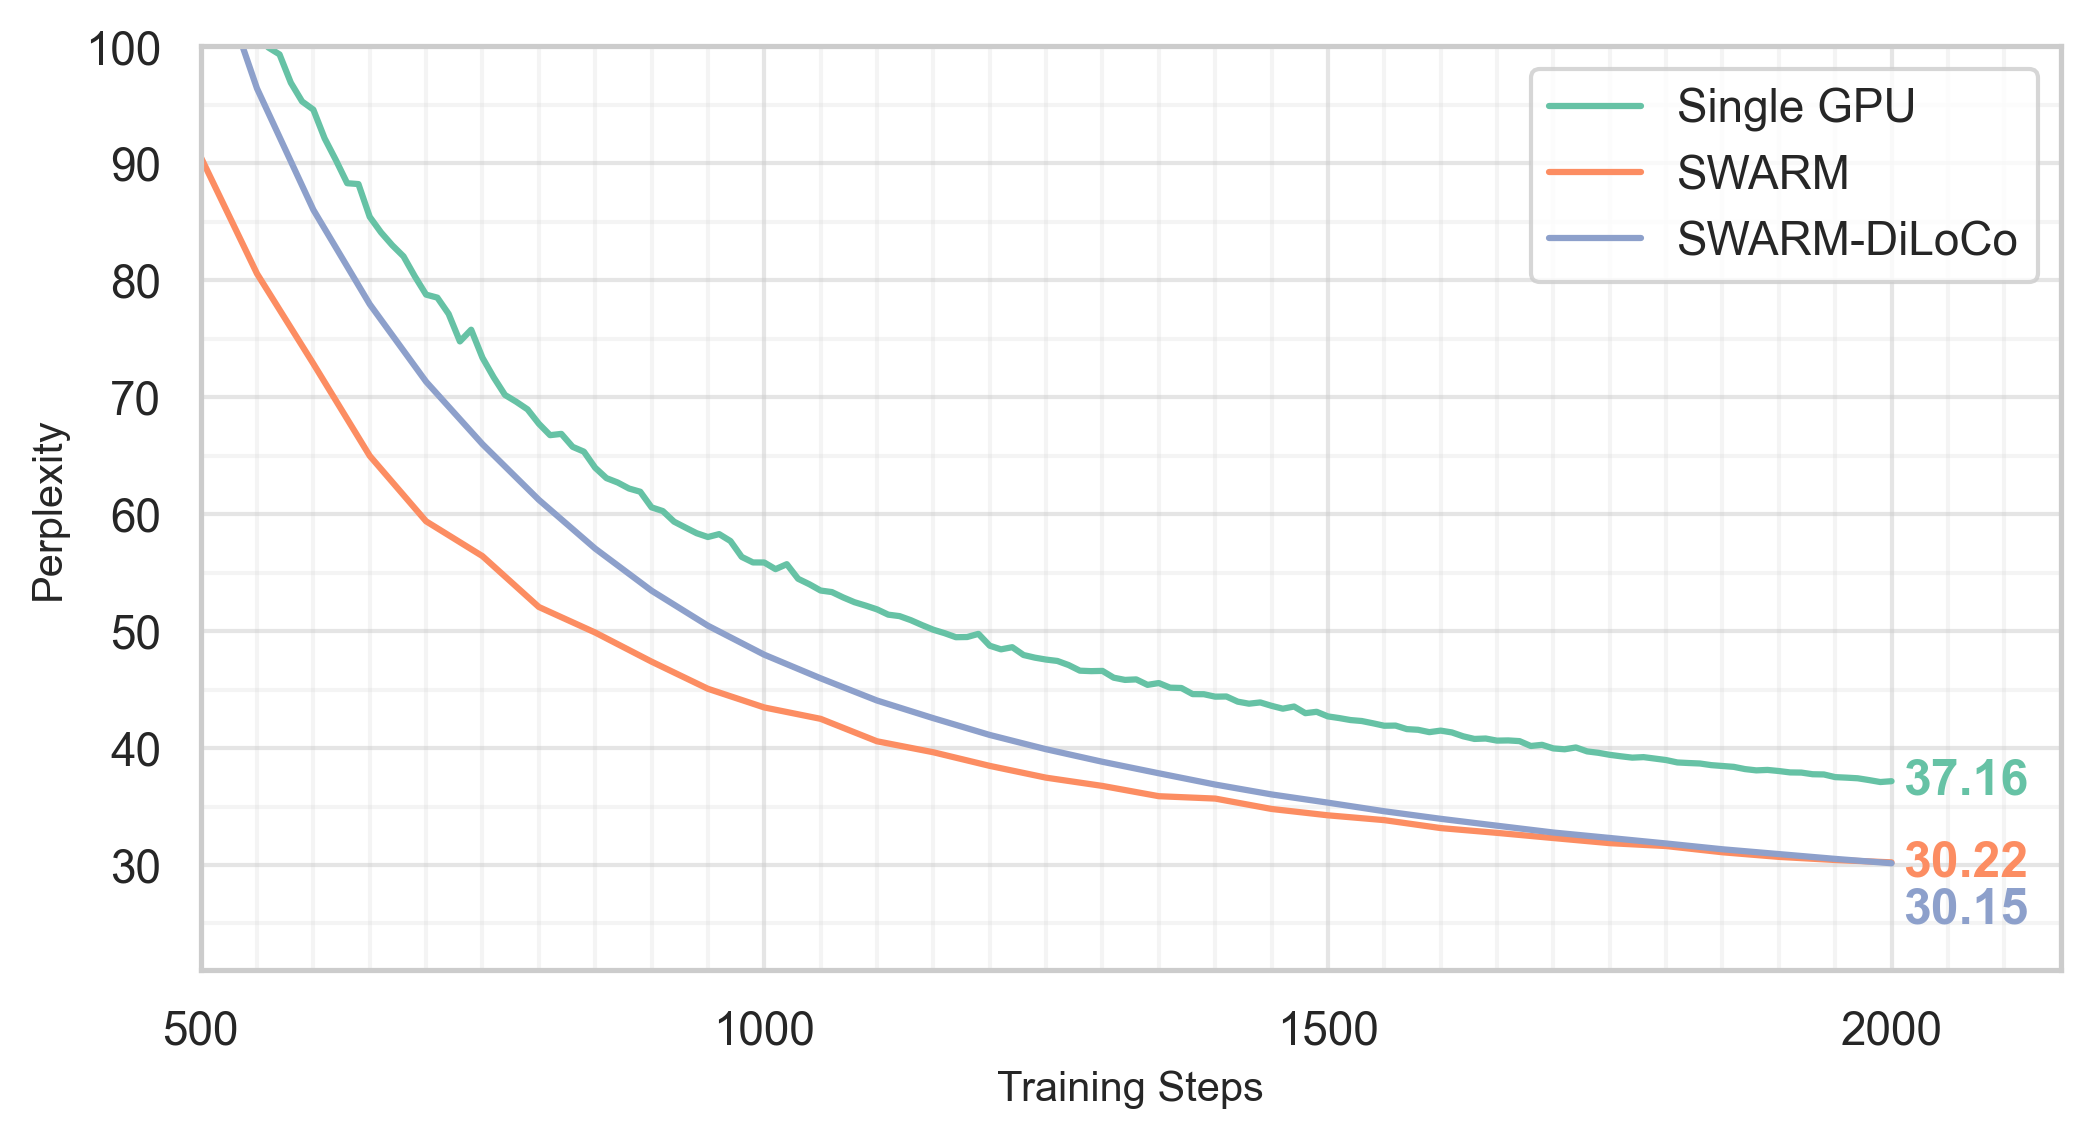

In [17]:
# Plot the validation perplexity against steps
fig, ax = plot_perplexity(exp1, figsize=(8, 4), fontsize=10)

# Add final perplexity values to the plot
colors = sns.color_palette("Set2", n_colors=exp1["group"].nunique())
order = exp1.groupby("group")["val_perplexity"].last().sort_values(ascending=False).index
for i, group in enumerate(order):
    group_data = exp1[exp1["group"] == group]
    final_val = group_data["val_perplexity"].iloc[-1]
    ax.text(2010, group_data["val_perplexity"].iloc[-1] - (4 if group == "SWARM-DiLoCo" else 0), f'{final_val:.2f}', color=colors[i], va='center', weight='bold', fontsize=12)

fig.savefig("report/figures/experiment1.png", bbox_inches="tight")

## Experiment 2: DiLoCo-SWARM vs. DiLoCo

We additionally train DiLoCo against the strong DDP baseline.

* Single GPU: A weak baseline, trained on 1B tokens (B=512, L=1024, N=2000)
* DDP: A strong baseline, trained on 8B tokens (B=2048, L=1024, N=2000)
* DiLoCo: Same as DDP, but with DiLoCo-style gradient synchronization every 50 steps (B=2048, L=1024, N=2000)

We want to get the runs and plot the validation perplexity against the number of training steps, as well as the wall-clock time.

In [18]:
# Load runs
GROUPS = {"Single-GPU": "20241229_181044", "DDP": "20241230_091409", "DiLoCo": "20241230_105725"}
MASTER_RUNS = {"Single GPU": "8eqzu96q", "DDP": "cjs5zgu1", "DiLoCo": "ba6izo3y"}
RUNS = [r for r in ALL_RUNS if r.group in GROUPS.values()]

print(f"✅ Loaded {len(RUNS)} runs.")

✅ Loaded 17 runs.


In [19]:
# Get config and summary
runs_config, runs_summary = [], []
run_id_to_run = {}
for run in tqdm(RUNS):
    run_id, group, name, config, summary = get_metadata(run)
    run_id_to_run[run_id] = run
    runs_config.append({"group": group, "name": name, "run_id": run_id, **config})
    runs_summary.append({"group": group, "name": name, **summary})

runs_config = pd.DataFrame(runs_config).set_index(["group", "name"])
runs_summary = pd.DataFrame(runs_summary).set_index(["group", "name"])

100%|██████████| 17/17 [00:00<00:00, 19402.22it/s]


In [20]:
# Get history from master runs
runs_history = pd.DataFrame()
for group, run_id in MASTER_RUNS.items():
    history = pd.DataFrame(list(run_id_to_run[run_id].scan_history()))
    history["group"] = group
    runs_history = pd.concat([runs_history, history])

In [21]:
# Prepare 
cols = {"group": "group", "_step": "step", "eval/perplexity/average": "val_perplexity", "train/global/perplexity/current": "train_perplexity"}
exp2 = runs_history[cols.keys()].rename(columns=cols)[list(cols.values())]
exp2 = exp2.dropna().reset_index(drop=True)
exp2.head()

,group,step,val_perplexity,train_perplexity
0,Single GPU,10,11956.535979,12948.691247
1,Single GPU,20,4645.202834,5191.030441
2,Single GPU,30,1828.546534,1924.651132
3,Single GPU,40,1209.697769,1218.613176
4,Single GPU,50,914.590837,930.700474


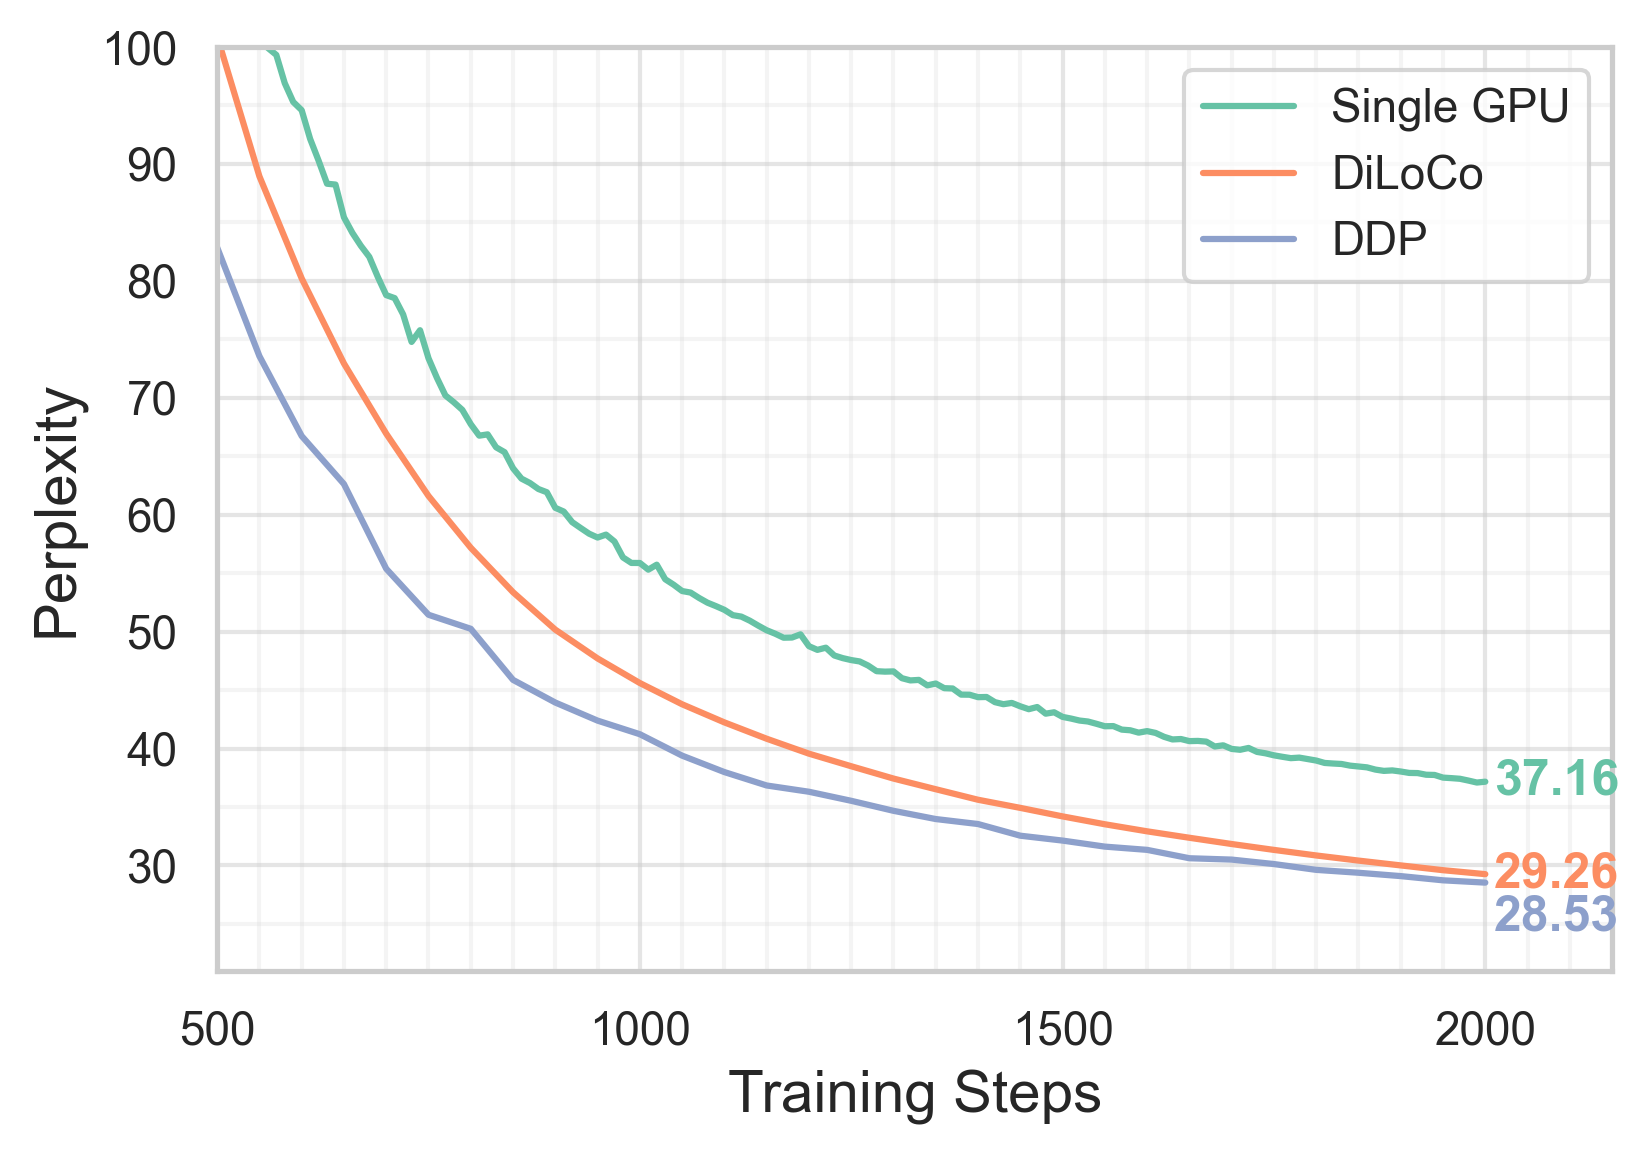

In [22]:
# Plot the validation perplexity against steps
fig, ax = plot_perplexity(exp2, figsize=(6, 4))

# Add final perplexity values to the plot
colors = sns.color_palette("Set2", n_colors=exp2["group"].nunique())
order = exp2.groupby("group")["val_perplexity"].last().sort_values(ascending=False).index
for i, group in enumerate(order):
    group_data = exp2[exp2["group"] == group]
    final_val = group_data["val_perplexity"].iloc[-1]
    ax.text(2010, group_data["val_perplexity"].iloc[-1] - (3 if group == "DDP" else 0), f'{final_val:.2f}', color=colors[i], va='center', weight='bold', fontsize=12)

fig.savefig("report/figures/experiment2.png", bbox_inches="tight")